In [1]:
import sys
# sys.path.append("../../PathPlanning/CubicSpline/")
import networkx as nx
import numpy as np
import math
# import cvxpy
import matplotlib.pyplot as plt
import cubic_spline_planner
import joblib

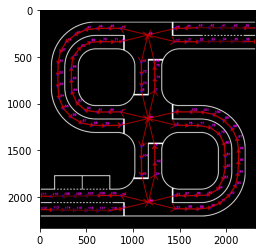

In [2]:
G = nx.read_graphml('test_track.graphml')
import cv2
img=cv2.imread("Test_track.png")
plt.imshow(img)

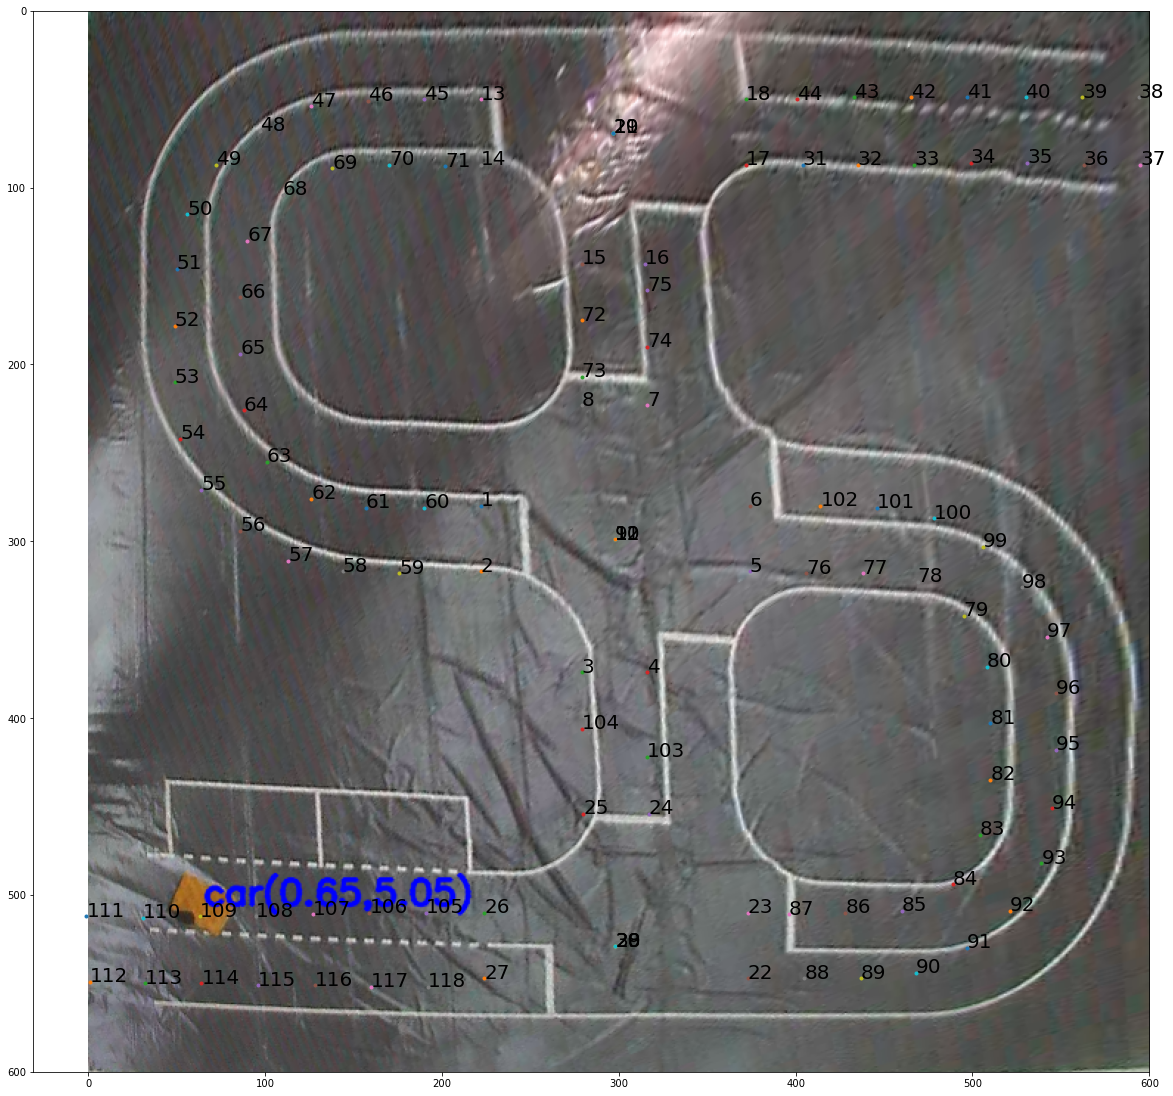

In [3]:
img=cv2.imread("TrackImageToday.png")
img=cv2.flip(img,0)
fig,ax=plt.subplots(figsize=(20,20))

ax.imshow(img,extent=[0,600,0,600])
for node,data in G.nodes(data=True):
    ax.plot(data['x']*100,data['y']*100,'.')
    ax.annotate(str(node), (data['x']*100,data['y']*100),size=20) 
ax.invert_yaxis()

In [4]:
ax=[52,150,251,385,422,415,409,398,390,440,512,569,638]
ay=[645,652,655,631,582,501,331,181,120,80,81,86,93]
ax=[i*6/7.2 for i in ax]
ay=[i*6/7.2 for i in ay]

In [7]:
cx, cy, cyaw, ck, s = cubic_spline_planner.calc_spline_course(
        ax, ay, ds=10)

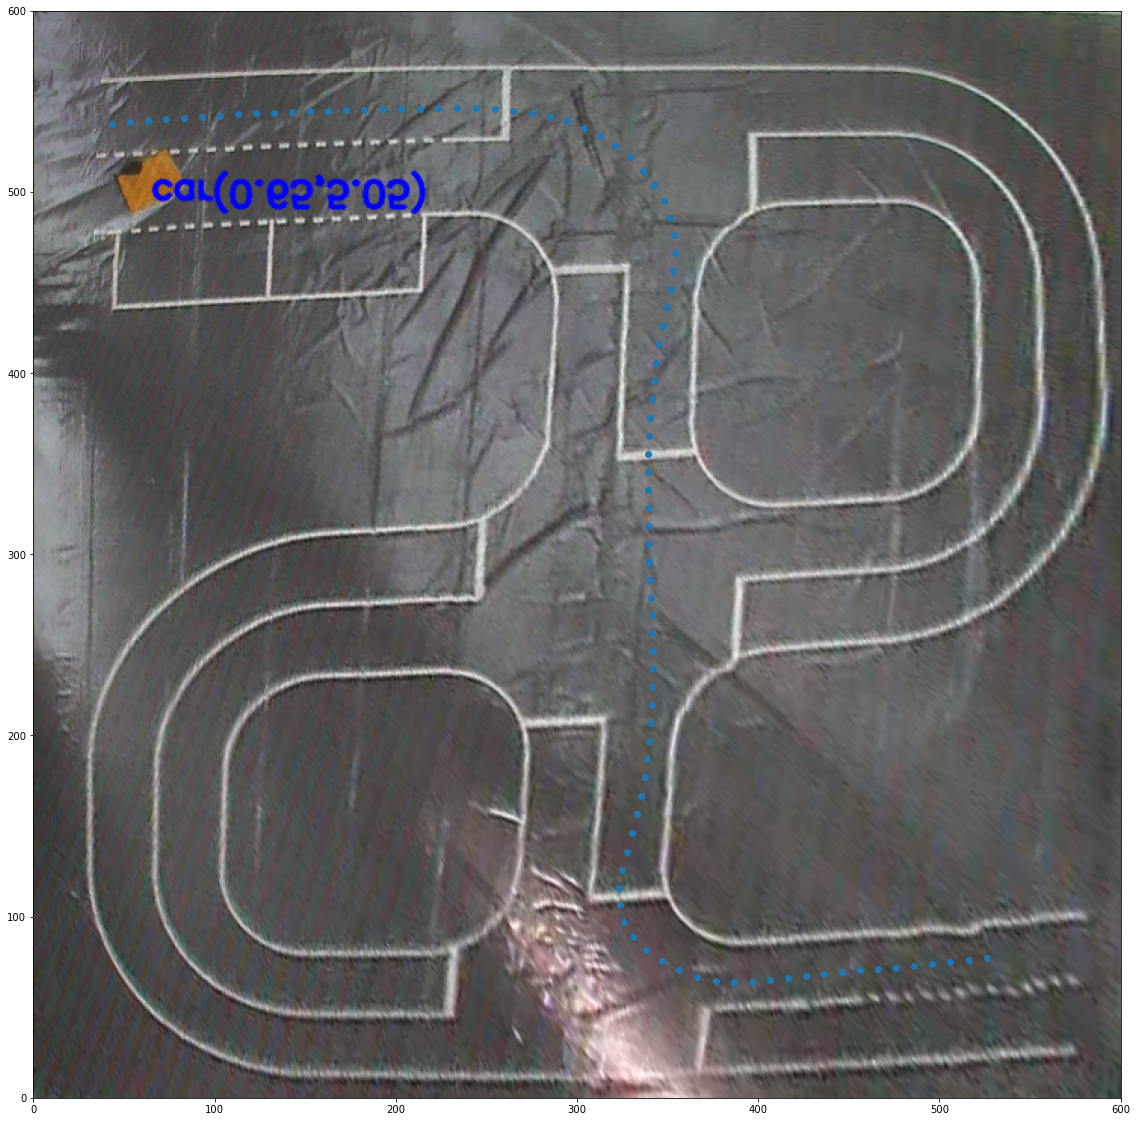

In [8]:
img=cv2.imread("TrackImageToday.png")
img=cv2.flip(img,0)
fig,px=plt.subplots(figsize=(20,20))

px.imshow(img,extent=[0,600,0,600])
plt.scatter(cx,cy)
cx=[i/100 for i in cx]
cy=[i/100 for i in cy]

In [10]:
cx,cy

([0.43333333333333335,
  0.5334228550732018,
  0.6334811521713754,
  0.7334769999861602,
  0.8333791738758624,
  0.9331564491987875,
  1.032777601313242,
  1.1322114055775312,
  1.2314266373499618,
  1.3304098747116546,
  1.429274103042566,
  1.5281870036989258,
  1.6273164767090973,
  1.726830422101445,
  1.826896739904331,
  1.9276833301461198,
  2.029358092855175,
  2.1320820939497263,
  2.2357379701392035,
  2.3398391128611804,
  2.44387346127402,
  2.5473289545360855,
  2.6496935318057404,
  2.7504551322413477,
  2.8491016950012718,
  2.945121159243875,
  3.0380014641275217,
  3.1272305488105734,
  3.2122963164170297,
  3.2923070464833,
  3.3650548846565225,
  3.4280469453401956,
  3.4787903429378173,
  3.514792191852884,
  3.534312602132963,
  3.5393173956817288,
  3.5329104358260794,
  3.518195891054852,
  3.4982779298568856,
  3.4762607207210188,
  3.4552462978494316,
  3.4374758668177914,
  3.4230149170479724,
  3.41159046598552,
  3.4029295310759773,
  3.3967591297648903,
  3

In [11]:
"""
Path tracking simulation with pure pursuit steering and PID speed control.
author: Atsushi Sakai (@Atsushi_twi)
        Guillaume Jacquenot (@Gjacquenot)
"""
import numpy as np
import math
import matplotlib.pyplot as plt

# Parameters
k = 0.01  # look forward gain
Lfc = .5  # [m] look-ahead distance
Kp = 1.0  # speed proportional gain
dt = 0.1  # [s] time tick
WB = 0.3  # [m] wheel base of vehicle

show_animation = True


class State:
    def __init__(self, v=14, dt=0.1, l=0.365) -> None:
        self.steering_angle = 0.0
        self.det_intersection = False
        self.x = cx[0]  # TODO
        self.y = cy[0]  # TODO
        self.yaw = 0
        self.tl = {}
        self.v = v
        self.dt = dt
        self.l = l
        self.rear_x = self.x - ((l / 2) * math.cos(self.yaw))
        self.rear_y = self.y - ((l / 2) * math.sin(self.yaw))

    def update_pos(self, steering_angle):
        self.x = self.x + self.v * math.cos(self.yaw) * self.dt
        self.y = self.y + self.v * math.sin(self.yaw) * self.dt
        self.yaw = (
            self.yaw + self.v / self.l * math.tan(steering_angle) * self.dt
        )  # steering_angle is the steering angle
        self.rear_x = self.x - ((WB / 2) * math.cos(self.yaw))
        self.rear_y = self.y - ((WB / 2) * math.sin(self.yaw))

    def update(
        self,
        angle: float,
        det_intersection: bool,
        x: float,
        y: float,
        yaw: float,
        tl: dict,
    ) -> None:
        self.steering_angle = angle
        self.det_intersection = det_intersection
        self.x = x
        self.y = y
        self.yaw = yaw
        self.tl = tl
        
    def calc_distance(self, point_x, point_y):
        dx = self.rear_x - point_x
        dy = self.rear_y - point_y
        return math.hypot(dx, dy)
    
    def __repr__(self) -> str:
        return f"{datetime.datetime.now()}| {self.steering_angle}, {self.det_intersection}, {self.x}, {self.y}, {self.yaw}"

    def asdict(self) -> dict:
        return {"angle": self.steering_angle, "intersection": self.det_intersection}


class States:

    def __init__(self):
        self.x = []
        self.y = []
        self.yaw = []
        self.v = []
        self.t = []

    def append(self, t, state):
        self.x.append(state.x)
        self.y.append(state.y)
        self.yaw.append(state.yaw)
        self.v.append(state.v)
        self.t.append(t)


def proportional_control(target, current):
    a = Kp * (target - current)

    return a


class TargetCourse:

    def __init__(self, cx, cy):
        self.cx = cx
        self.cy = cy
        self.old_nearest_point_index = None

    def search_target_index(self, state):

        # To speed up nearest point search, doing it at only first time.
        if self.old_nearest_point_index is None:
            # search nearest point index
            dx = [state.rear_x - icx for icx in self.cx]
            dy = [state.rear_y - icy for icy in self.cy]
            d = np.hypot(dx, dy)
            ind = np.argmin(d)
            self.old_nearest_point_index = ind
        else:
            ind = self.old_nearest_point_index
            distance_this_index = state.calc_distance(self.cx[ind],
                                                      self.cy[ind])
            while True:
                distance_next_index = state.calc_distance(self.cx[ind + 1],
                                                          self.cy[ind + 1])
                if distance_this_index < distance_next_index:
                    break
                ind = ind + 1 if (ind + 1) < len(self.cx) else ind
                distance_this_index = distance_next_index
            self.old_nearest_point_index = ind

        Lf = k * state.v + Lfc  # update look ahead distance

        # search look ahead target point index
        while Lf > state.calc_distance(self.cx[ind], self.cy[ind]):
            if (ind + 1) >= len(self.cx):
                break  # not exceed goal
            ind += 1

        return ind, Lf


def pure_pursuit_steer_control(state, trajectory, pind):
    ind, Lf = trajectory.search_target_index(state)

    if pind >= ind:
        ind = pind

    if ind < len(trajectory.cx):
        tx = trajectory.cx[ind]
        ty = trajectory.cy[ind]
    else:  # toward goal
        tx = trajectory.cx[-1]
        ty = trajectory.cy[-1]
        ind = len(trajectory.cx) - 1

    alpha = math.atan2(ty - state.rear_y, tx - state.rear_x) - state.yaw
    # print(math.degrees(alpha))
    
    delta = math.atan2(2.0 * WB * math.sin(alpha) / Lf, 1.0)
    
    if abs(math.degrees(delta))>21:
        print("hmmyes",math.degrees(delta))

    return delta, ind


def plot_arrow(x, y, yaw, length=.01, width=0.005, fc="r", ec="k"):
    """
    Plot arrow
    """

    if not isinstance(x, float):
        for ix, iy, iyaw in zip(x, y, yaw):
            plot_arrow(ix, iy, iyaw)
    else:
        plt.arrow(x, y, length * math.cos(yaw), length * math.sin(yaw),
                  fc=fc, ec=ec, head_width=width, head_length=width)
        plt.plot(x, y)

Pure pursuit path tracking simulation start
hmmyes -22.79493132141742
hmmyes -22.406720909798732
hmmyes -22.096587988938545
hmmyes -21.869889683471595
hmmyes -24.30852543334194
hmmyes -23.931066391767285
hmmyes -23.634965242492274
hmmyes -25.934172384139128
hmmyes -25.48668313419598
hmmyes -25.117108832978552
hmmyes -24.830828086367855
hmmyes -26.630177536682375
hmmyes -26.182022270244094
hmmyes -25.812122394527524
hmmyes -25.52601488646123
hmmyes -26.557830111371526
hmmyes -26.105219321007056
hmmyes -25.73052072409918
hmmyes -25.439196571790067
hmmyes -25.52817959124881
hmmyes -25.07753374127992
hmmyes -24.704270023297305
hmmyes -24.413615251169603
hmmyes -23.46169787398008
hmmyes -23.03289037953153
hmmyes -22.680422506500978
hmmyes -22.409200590098067
hmmyes 25.498852313912025
hmmyes 25.124464360640598
hmmyes 24.833009607678765
hmmyes 30.276410489010335
hmmyes 29.804527331694846
hmmyes 29.407988383071412
hmmyes 29.09263367718871
hmmyes 32.97277419042023
hmmyes 32.46369945962235
hmmye

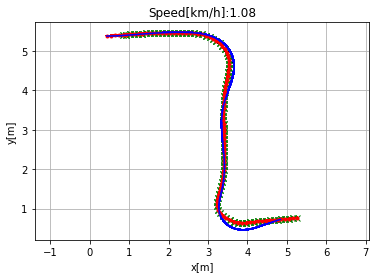

In [12]:

di_arr=[]
def main():
    #  target course
    # cx, cy = cx,cy
    target_speed = 10.0 / 3.6  # [m/s]

    T = 100.0  # max simulation time

    # initial state
    state = State(v=0.3)

    lastIndex = len(cx) - 1
    time = 0.0
    states = States()
    states.append(time, state)
    target_course = TargetCourse(cx, cy)
    target_ind, _ = target_course.search_target_index(state)

    while T >= time and lastIndex > target_ind:

        # Calc control input
        ai = proportional_control(target_speed, state.v)
        di, target_ind = pure_pursuit_steer_control(
            state, target_course, target_ind)
        di_arr.append(di)
        state.update_pos(di)  # Control vehicle

        time += dt
        states.append(time, state)

        if show_animation:  # pragma: no cover
            # plt.cla()
            # for stopping simulation with the esc key.
            # plt.gcf().canvas.mpl_connect(
            #     'key_release_event',
            #     lambda event: [exit(0) if event.key == 'escape' else None])
            plot_arrow(state.x, state.y, state.yaw)
            plt.plot(cx, cy, "-r", label="course")
            plt.plot(states.x, states.y, "-b", label="trajectory")
            plt.plot(cx[target_ind], cy[target_ind], "xg", label="target")
            plt.axis("equal")
            plt.grid(True)
            plt.title("Speed[km/h]:" + str(state.v * 3.6)[:4])
            # plt.pause(0.001)

    # Test
    assert lastIndex >= target_ind, "Cannot goal"

    if show_animation:  # pragma: no cover
        # plt.cla()
        plt.plot(cx, cy, ".r", label="course")
        plt.plot(states.x, states.y, "-b", label="trajectory")
        plt.xlabel("x[m]")
        plt.ylabel("y[m]")
        plt.axis("equal")
        plt.grid(True)

        # plt.subplots(1)
        #plt.plot(states.t, [iv * 3.6 for iv in states.v], "-r")
        #plt.xlabel("Time[s]")
        #plt.ylabel("Speed[km/h]")
        #plt.grid(True
        # plt.show()
    return states


if __name__ == '__main__':
    print("Pure pursuit path tracking simulation start")
    main()

hmmyes -22.79493132141742
hmmyes -22.406720909798732
hmmyes -22.096587988938545
hmmyes -21.869889683471595
hmmyes -24.30852543334194
hmmyes -23.931066391767285
hmmyes -23.634965242492274
hmmyes -25.934172384139128
hmmyes -25.48668313419598
hmmyes -25.117108832978552
hmmyes -24.830828086367855
hmmyes -26.630177536682375
hmmyes -26.182022270244094
hmmyes -25.812122394527524
hmmyes -25.52601488646123
hmmyes -26.557830111371526
hmmyes -26.105219321007056
hmmyes -25.73052072409918
hmmyes -25.439196571790067
hmmyes -25.52817959124881
hmmyes -25.07753374127992
hmmyes -24.704270023297305
hmmyes -24.413615251169603
hmmyes -23.46169787398008
hmmyes -23.03289037953153
hmmyes -22.680422506500978
hmmyes -22.409200590098067
hmmyes 25.498852313912025
hmmyes 25.124464360640598
hmmyes 24.833009607678765
hmmyes 30.276410489010335
hmmyes 29.804527331694846
hmmyes 29.407988383071412
hmmyes 29.09263367718871
hmmyes 32.97277419042023
hmmyes 32.46369945962235
hmmyes 32.02277448286967
hmmyes 31.65573114466718

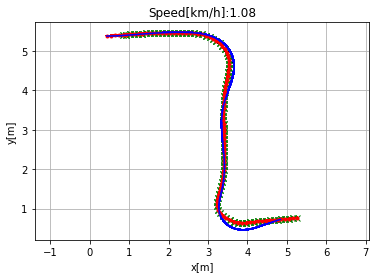

In [13]:
ret=main()

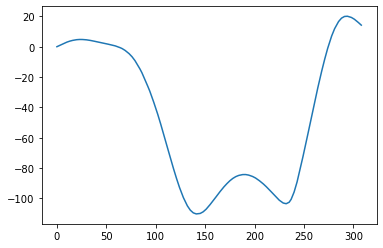

In [14]:
plt.plot([i*180/math.pi for i in ret.yaw])

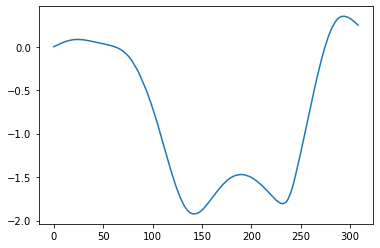

In [15]:
plt.plot(ret.yaw)

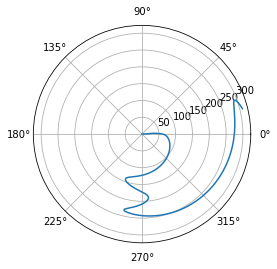

In [16]:
plt.clf()
sp = plt.subplot(1, 1, 1, projection='polar')
sp.set_theta_zero_location('E')
# sp.set_theta_direction(-1)
plt.plot(ret.yaw,[i for i in range(len(ret.yaw))])
plt.show()

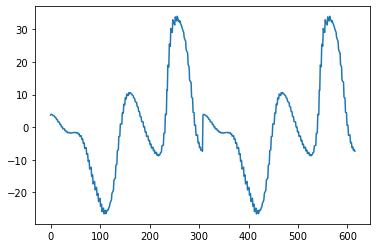

In [17]:
di_arr=[i*180/math.pi for i in di_arr]
plt.plot(di_arr)

In [18]:
joblib.dump({
'x':cx,"y":cy},
"path.z")

['path.z']

In [15]:
cx

[0.43333333333333335,
 0.7334782167192219,
 1.0327789026366971,
 1.3304090181131871,
 1.6273122715012551,
 1.9276796040349833,
 2.2357436727832916,
 2.5473493531490745,
 2.849128703940845,
 3.1272422346075093,
 3.3650246431161848,
 3.514789492251189,
 3.5330685683813887,
 3.4763725958632294,
 3.422491394198657,
 3.3952757765637904,
 3.38832117201392,
 3.3948885479970725,
 3.4082388719612755]

In [16]:
cy

[5.375,
 5.399206687172543,
 5.420777729826494,
 5.437096730434421,
 5.447458635270175,
 5.454664770993198,
 5.461396724255643,
 5.456763260609604,
 5.414965281234685,
 5.309440642282311,
 5.117332536650728,
 4.856460526791408,
 4.565010233123334,
 4.261050571123405,
 3.956337449625672,
 3.6546373612678087,
 3.3552354477843,
 3.057367311303062,
 2.760268553952013]

In [17]:
# hmm=[(0.35, 5.2, 0.0), (0.35, 5.2, 0.0), (0.35, 5.2, 3.141592653589793), (0.35, 5.2, 0.0011111111380159853), (0.35, 5.2, 0.0022222222760319705), (0.35, 5.2, 0.0022222222760319705), (0.35, 5.2, 0.0022222222760319705), (0.35, 5.2, 0.0022222222760319705), (0.35, 5.2, 0.0), (0.35, 5.2, 0.0), (0.35, 5.2, 0.0), (0.35, 5.2, 0.0), (0.35, 5.2, 0.0), (0.35, 5.2, 3.141592653589793), (0.35, 5.2, 0.0022222222760319705), (0.35, 5.2, 0.0022222222760319705), (0.35, 5.2, -0.003185097371237018), (0.35, 5.2, -0.003185097371237018), (0.35, 5.2, -0.003185097371237018), (0.35, 5.2, 3.141592653589793), (0.35, 5.2, -0.003185097371237018), (0.35, 5.2, 3.141592653589793), (0.35, 5.2, 3.141592653589793), (0.35, 5.2, -0.003185097371237018), (0.35, 5.2, 3.141592653589793), (0.35, 5.2, -0.003185097371237018), (0.35, 5.2, 3.141592653589793), (0.35, 5.2, -0.003185097371237018), (0.35, 5.2, 3.141592653589793), (0.35, 5.2, 3.141592653589793), (0.35, 5.2, -0.0009630362140103581), (0.35, 5.2, 3.141592653589793), (0.35, 5.2, -0.0009630362140103581), (0.37, 5.29, 3.141592653589793), (0.37, 5.29, 0.0011111111380159853), (0.37, 5.28, 0.02666666731238365), (0.37, 5.28, 0.02222222276031971), (0.37, 5.28, -0.01874095598329709), (0.37, 5.28, -0.0531852881061004), (0.37, 5.28, 3.141592653589793), (0.4, 5.3, -0.09540731111635382), (0.39, 5.2, 3.141592653589793), (0.4, 5.22, 3.141592653589793), (0.41, 5.21, -0.13318521181215495), (0.44, 5.21, 3.141592653589793), (0.46, 5.21, -0.16985208192934173), (0.48, 5.21, 3.141592653589793), (0.5, 5.2, 3.141592653589793), (0.52, 5.2, -0.20540744463075838), (0.54, 5.2, 3.141592653589793), (0.57, 5.19, -0.17096311250795507), (0.6, 5.18, -0.16985208192934173), (0.62, 5.17, -0.2165187040912073), (0.66, 5.16, -0.2431853453265585), (0.69, 5.16, -0.28874093690981073), (0.73, 5.16, -0.33429652849306296), (0.77, 5.15, 3.141592653589793), (0.8, 5.14, 3.141592653589793), (0.82, 5.13, -0.35429650941957636), (0.86, 5.11, -0.35429650941957636), (0.88, 5.1, -0.35429650941957636), (0.9, 5.09, 3.141592653589793), (0.91, 5.09, -0.35429650941957636), (0.91, 5.09, -0.35429650941957636), (0.91, 5.09, -0.35429650941957636), (0.91, 5.09, -0.35429650941957636), (0.91, 5.09, 3.141592653589793), (0.91, 5.09, -0.35429650941957636), (0.91, 5.09, 3.141592653589793), (0.91, 5.09, 3.141592653589793), (0.91, 5.09, -0.33762962022890297), (0.91, 5.09, 3.141592653589793), (0.91, 5.08, -0.2942965666400352), (0.9, 5.09, 3.141592653589793), (0.92, 5.09, -0.25874072710146173), (0.94, 5.08, 3.141592653589793), (0.96, 5.08, -0.2642963568316862), (0.99, 5.08, -0.24540740648378515), (1.04, 5.07, -0.19651872316469393), (1.07, 5.07, -0.2787407080279751), (1.11, 5.06, -0.3654072920428675), (1.11, 5.06, 3.141592653589793), (1.13, 5.06, 3.141592653589793), (1.16, 5.06, -0.43762952486147094), (1.2, 5.05, -0.4609630743609831), (1.29, 5.02, -0.4831851164447231), (1.34, 5.0, -0.5154073874102988), (1.37, 4.98, -0.5654075781451622), (1.39, 4.96, -0.62429649034609), (1.42, 4.94, -0.6642964521991178), (1.42, 4.94, -0.7342966238604945), (1.42, 4.94, -0.7998521963702602), (1.44, 4.92, -0.8554075399981902), (1.45, 4.93, 3.141592653589793), (1.46, 4.91, -0.9076297918902793), (1.49, 4.87, 3.141592653589793), (1.52, 4.84, -0.966518704091207), (1.56, 4.83, -1.0254076162921348), (1.59, 4.78, -1.0887406508075161), (1.62, 4.76, -1.1265185515033171), (1.63, 4.73, -1.1387408415423794), (1.65, 4.69, 3.141592653589793), (1.68, 4.67, 3.141592653589793), (1.69, 4.65, -1.1365187803851529), (1.69, 4.62, 3.141592653589793), (1.72, 4.58, -1.1542962233172818), (1.73, 4.53, 3.141592653589793), (1.75, 4.51, -1.1254075209247036), (1.76, 4.46, 3.141592653589793), (1.76, 4.42, 3.141592653589793), (1.77, 4.4, -1.093185249959127), (1.77, 4.37, 3.141592653589793), (1.8, 4.32, -1.1265185515033171), (1.82, 4.28, 3.141592653589793), (1.85, 4.21, 3.141592653589793), (1.89, 4.11, -1.0754073301898404), (1.91, 4.04, 3.141592653589793), (1.93, 3.99, -1.028740708027975), (1.95, 3.95, 3.141592653589793), (1.97, 3.94, -0.9620741049395959), (1.97, 3.93, 3.141592653589793), (1.98, 3.9, 3.141592653589793), (2.01, 3.86, -0.9720743338214315), (2.03, 3.82, -0.9709633032428182), (2.07, 3.77, -0.925407711659567), (2.15, 3.67, -0.9487407843219203), (2.19, 3.64, -1.0054076353656216), (2.23, 3.6, 3.141592653589793), (2.25, 3.52, -1.074296299611227), (2.29, 3.47, 3.141592653589793), (2.32, 3.44, -1.1665185133563438), (2.35, 3.43, 3.141592653589793), (2.34, 3.42, 3.141592653589793), (2.34, 3.42, -1.2320740858661094), (2.34, 3.38, 3.141592653589793), (2.39, 3.28, -1.2742965857135218), (2.4, 3.23, 3.141592653589793), (2.4, 3.18, -1.3031852881060997), (2.41, 3.15, 3.141592653589793), (2.41, 3.11, 3.141592653589793), (2.4, 3.1, -1.3320739904986785), (2.4, 3.08, 3.141592653589793), (2.4, 3.05, -1.3654072920428675), (2.4, 3.04, 3.141592653589793), (2.4, 3.04, 3.141592653589793), (2.41, 2.98, -1.4487407843219198), (2.42, 2.95, 3.141592653589793), (2.41, 2.9, -1.5287407080279753), (2.42, 2.85, 3.141592653589793), (2.4, 2.8, -1.617629830037252)]
hmm=[(0.31, 5.19, 0.0), (0.31, 5.19, 0.0), (0.31, 5.19, 3.141592653589793), (0.32, 5.19, 0.0), (0.31, 5.19, 3.141592653589793), (0.31, 5.2, 3.141592653589793), (0.31, 5.19, 0.0033333334140479565), (0.32, 5.2, 0.015379225727319605), (0.31, 5.2, 0.014268195148706277), (0.31, 5.2, 0.014268195148706277), (0.32, 5.2, 0.014268195148706277), (0.32, 5.2, 3.141592653589793), (0.32, 5.19, 0.014268195148706277), (0.32, 5.19, 3.141592653589793), (0.32, 5.2, 0.014268195148706277), (0.32, 5.2, 3.141592653589793), (0.32, 5.2, 3.141592653589793), (0.32, 5.19, 0.014268195148706277), (0.32, 5.19, 3.141592653589793), (0.32, 5.19, 0.014268195148706277), (0.32, 5.2, 0.014268195148706277), (0.32, 5.19, 3.141592653589793), (0.32, 5.2, 0.014268195148706277), (0.32, 5.19, 0.0011111111380159853), (0.32, 5.19, 0.016490256305932937), (0.32, 5.19, 0.014268195148706277), (0.32, 5.2, 0.014268195148706277), (0.32, 5.2, 0.014268195148706277), (0.32, 5.2, 0.014268195148706277), (0.32, 5.2, 3.141592653589793), (0.32, 5.2, 3.141592653589793), (0.32, 5.2, 0.014268195148706277), (0.32, 5.2, 3.141592653589793), (0.32, 5.2, 0.0011111111380159853), (0.32, 5.2, 3.141592653589793), (0.32, 5.2, 3.141592653589793), (0.32, 5.19, 0.0011111111380159853), (0.32, 5.19, 3.141592653589793), (0.32, 5.2, 0.014268195148706277), (0.32, 5.2, 3.141592653589793), (0.32, 5.2, 3.141592653589793), (0.32, 5.2, 0.0011111111380159853), (2.95, 3.56, 3.141592653589793), (2.36, 3.08, 0.0011111111380159853), (1.86, 3.04, 3.141592653589793), (0.33, 5.22, 0.0011111111380159853), (0.33, 5.22, 0.0033333334140479565), (0.33, 5.23, 0.0033333334140479565), (0.37, 5.24, 0.03222222253680229), (0.42, 5.21, 0.14777778089046478), (0.5, 5.21, 3.141592653589793), (0.58, 5.22, 0.25555557012557983), (0.64, 5.23, 3.141592653589793), (0.72, 5.25, 0.3466666638851166), (0.8, 5.28, 0.2611111104488373), (0.92, 5.33, 0.3655555546283722), (1.0, 5.37, 0.49444442987442017), (1.07, 5.42, 0.6100000143051147), (1.14, 5.44, 0.5922222137451172), (1.23, 5.47, 0.6000000238418579), (1.31, 5.51, 0.7477777600288391), (1.37, 5.55, 0.8666666746139526), (1.43, 5.6, 0.9055555462837219), (1.49, 5.64, 1.0444444417953491), (1.55, 5.71, 1.1622222661972046), (1.62, 5.75, 1.2688888311386108), (1.7, 5.8, 1.3744444847106936), (1.8, 5.83, 1.4822221994400024), (1.85, 5.86, 1.5833333730697632), (1.9, 5.9, 1.6977777481079102), (1.95, 5.93, 1.8088889122009277), (0.18, 3.41, 1.9222222566604614), (2.23, 3.85, 2.035555601119995)]
# hmm=[(0.62, 5.25, 0.0), (0.62, 5.25, 0.016490256305932937), (0.62, 5.25, 3.141592653589793), (0.62, 5.25, 0.006666666828095913), (0.62, 5.25, 0.0811111107468605), (0.62, 5.25, 0.1644444465637207), (0.64, 5.25, 0.22333332896232605), (0.69, 5.25, 0.1455555558204651), (0.75, 5.26, 0.058888889849185944), (0.8, 5.26, -0.01239844608664491), (0.85, 5.28, -0.10795422840476052), (0.9, 5.3, 3.141592653589793), (0.95, 5.32, 3.141592653589793), (1.0, 5.33, -0.20239850330710402), (1.05, 5.33, 3.141592653589793), (1.1, 5.33, -0.1579544191396239), (1.15, 5.33, 3.141592653589793), (1.21, 5.32, -0.08239861774802168), (1.26, 5.31, 3.141592653589793), (1.3, 5.29, 3.141592653589793), (1.35, 5.28, -0.03350993442893044), (1.4, 5.26, 3.141592653589793), (1.44, 5.26, -0.025732243541479308), (1.49, 5.25, 3.141592653589793), (1.53, 5.26, 0.012222222052514553), (1.58, 5.27, 3.141592653589793), (1.62, 5.26, 3.141592653589793), (1.68, 5.28, 0.08777777850627898), (1.72, 5.26, 0.12444444745779037), (1.77, 5.27, 3.141592653589793), (1.81, 5.28, 0.12666666507720947), (1.86, 5.28, 0.13333334028720856), (1.9, 5.3, 0.19777777791023254), (1.96, 5.31, 0.20888888835906982), (2.0, 5.32, 3.141592653589793), (2.04, 5.33, 0.20666666328907013), (2.09, 5.33, 0.2544444501399994), (2.13, 5.34, 0.25111111998558044), (2.18, 5.35, 0.21666666865348816), (2.23, 5.37, 0.15000000596046448), (2.27, 5.38, 0.12222222238779068), (2.32, 5.39, 0.03444444388151169), (2.36, 5.4, -0.03462096500754377), (2.45, 5.42, 3.141592653589793), (2.49, 5.44, -0.12350961017966279), (2.58, 5.45, 3.141592653589793), (2.63, 5.46, 3.141592653589793), (2.71, 5.46, -0.21795436191916404), (2.77, 5.47, -0.25239869404196735), (2.85, 5.45, -0.18239852238059062), (2.89, 5.46, -0.10906525898337385), (2.94, 5.43, -0.03462096500754377), (2.98, 5.41, 0.025555554777383804), (3.02, 5.4, 3.141592653589793), (3.07, 5.38, 3.141592653589793), (3.1, 5.35, 0.09777777642011642), (3.15, 5.34, 3.141592653589793), (3.19, 5.34, 0.1733333319425583), (3.23, 5.35, 3.141592653589793), (3.28, 5.34, 0.25), (3.32, 5.35, 0.2477777749300003), (3.35, 5.35, 0.2522222101688385), (3.4, 5.35, 0.2522222101688385), (3.45, 5.36, 0.2522222101688385), (3.49, 5.37, 3.141592653589793), (3.54, 5.38, 0.25333333015441895), (3.58, 5.39, 3.141592653589793), (3.61, 5.41, 0.22777777910232544), (3.65, 5.42, 3.141592653589793), (3.71, 5.44, 0.21666666865348816), (3.73, 5.44, 0.2855555415153503), (3.72, 5.44, 0.3566666543483734), (3.73, 5.44, 0.42888888716697693), (3.72, 5.44, 0.49888888001441956), (3.72, 5.44, 3.141592653589793), (3.72, 5.44, 3.141592653589793), (3.73, 5.44, 0.5522222518920898), (3.72, 5.44, 0.4677777886390686), (3.73, 5.44, 0.4011111259460449), (3.77, 5.46, 0.3477777838706971), (3.82, 5.46, 0.4011111259460449), (3.86, 5.45, 3.141592653589793), (3.89, 5.46, 3.141592653589793), (3.93, 5.5, 0.47333332896232605), (3.98, 5.51, 0.4977777898311615), (4.0, 5.51, 0.48444443941116333), (4.04, 5.55, 0.47999998927116394), (4.07, 5.57, 0.5166666507720947), (4.09, 5.58, 0.5522222518920898), (4.14, 5.62, 0.5688889026641845), (4.16, 5.63, 0.5922222137451172), (4.2, 5.65, 0.6222222447395325), (4.24, 5.66, 0.6744444370269775)]
# hmm=[(0.72, 5.25, 0.0), (0.72, 5.25, 0.006490027424097334), (0.72, 5.25, 0.006490027424097334), (0.72, 5.26, -0.07684298801779721), (0.72, 5.25, -0.07684298801779721), (0.72, 5.26, -0.07684298801779721), (0.72, 5.26, -0.14462109852194732), (0.76, 5.26, -0.14462109852194732), (0.8, 5.25, -0.23128768253684065), (0.85, 5.24, -0.23128768253684065), (0.9, 5.22, -0.32573195743918415), (0.95, 5.2, -0.32573195743918415), (1.0, 5.18, -0.32573195743918415), (1.05, 5.16, -0.41239854145407645), (1.09, 5.12, -0.41239854145407645), (1.12, 5.1, -0.5023986940419676), (1.17, 5.07, -0.5023986940419676), (1.2, 5.03, -0.5468432550466056), (1.24, 5.0, -0.5468432550466056), (1.24, 5.0, -0.6068431978261467), (1.27, 4.98, -0.6068431978261467), (1.32, 4.93, -0.6068431978261467), (1.34, 4.9, -0.6857320909535879), (1.38, 4.86, -0.6857320909535879), (1.38, 4.86, -0.7479540948903557), (1.4, 4.82, -0.7479540948903557), (1.43, 4.78, -0.8479539995229247), (1.44, 4.75, -0.8479539995229247), (1.44, 4.75, -0.9401766901051993), (1.46, 4.69, -0.9401766901051993), (1.48, 4.65, -0.9401766901051993), (1.49, 4.61, -1.0268432741200928), (1.49, 4.61, -1.0268432741200928), (1.5, 4.57, -1.116842949870825), (1.5, 4.51, -1.116842949870825), (1.51, 4.48, -1.210176671031713), (1.5, 4.42, -1.210176671031713), (1.5, 4.42, -1.3023988847768309), (1.51, 4.38, -1.3023988847768309), (1.51, 4.33, -1.3023988847768309), (1.51, 4.28, -1.3935095911061763), (1.49, 4.23, -1.3935095911061763), (1.49, 4.23, -1.48462077427268), (1.5, 4.19, -1.48462077427268), (1.49, 4.14, -1.48462077427268), (1.47, 4.09, -1.5768429880177979), (1.46, 4.05, -1.5579540376698968), (1.46, 4.01, -1.4835097436940667), (1.47, 3.95, -1.406842911723852), (1.48, 3.92, -1.3323986177480218), (1.48, 3.87, -1.3323986177480218), (1.5, 3.82, -1.2612874155080318), (1.5, 3.78, -1.2612874155080318), (1.51, 3.73, -1.199065411571264), (1.53, 3.68, -1.280176365855932), (1.54, 3.65, -1.3690654878652098), (1.57, 3.61, -1.4579541330373287), (1.57, 3.57, -1.545732224467992), (1.58, 3.52, -1.545732224467992), (1.58, 3.47, -1.6357319002187245), (1.57, 3.42, -1.6357319002187245), (1.57, 3.38, -1.6479541902577877), (1.55, 3.34, -1.6479541902577877), (1.54, 3.29, -1.6479541902577877), (1.53, 3.24, -1.5757319574391846), (1.51, 3.2, -1.5757319574391846), (1.49, 3.15, -1.5646206979787343), (1.49, 3.11, -1.5646206979787343), (1.5, 3.06, -1.5646206979787343), (1.5, 3.0, -1.6479541902577877), (1.5, 2.97, -1.7146207933461666), (1.5, 2.92, -1.7112877016103267), (1.46, 2.88, -1.6423985605275635), (1.48, 2.85, -1.5701763277089589), (1.45, 2.8, -1.5168430452382564), (1.43, 2.76, -1.563509667400121), (1.42, 2.73, -1.6546208505666256), (1.42, 2.67, -1.6546208505666256), (1.4, 2.62, -1.7468430643117425), (1.42, 2.58, -1.7468430643117425), (1.43, 2.53, -1.7468430643117425), (1.42, 2.49, -1.7601763849294179)]

In [30]:
hmm=[(0.36, 5.22, -1.5707963267948966, (0.43333333333333335, 5.375), 21), (0.36, 5.22, -1.5696852156568806, (0.7334782167192219, 5.399206687172543), 21), (0.36, 5.22, -1.5696852156568806, (0.7334782167192219, 5.399206687172543), 21), (0.36, 5.22, -1.5641296599668006, (0.7334782167192219, 5.399206687172543), 21), (0.36, 5.22, -1.5641296599668006, (0.7334782167192219, 5.399206687172543), 21), (0.36, 5.22, -1.6162039240135444, (0.7334782167192219, 5.399206687172543), 21), (0.35, 5.21, -1.6162039240135444, (0.7334782167192219, 5.399206687172543), 21), (0.42, 5.23, -1.6162039240135444, (0.7334782167192219, 5.399206687172543), 21), (0.47, 5.23, -1.6884261568321488, (0.7334782167192219, 5.399206687172543), 21), (0.5, 5.23, -1.7462040384544633, (0.7334782167192219, 5.399206687172543), 21), (0.56, 5.21, -1.8317595918907426, (0.7334782167192219, 5.399206687172543), 21), (0.61, 5.21, -1.9228702982200883, (1.0327789026366971, 5.420777729826494), 21), (0.66, 5.2, -1.9784261186851761, (1.0327789026366971, 5.420777729826494), 21), (0.71, 5.17, -2.012870450807979, (1.0327789026366971, 5.420777729826494), 21), (0.77, 5.18, -2.1006480654014847, (0.7334782167192219, 5.399206687172543), -21), (0.81, 5.14, -2.186203618837764, (1.0327789026366971, 5.420777729826494), 21), (0.86, 5.12, -2.273981710268427, (1.0327789026366971, 5.420777729826494), -21), (0.91, 5.1, -2.273981710268427, (1.0327789026366971, 5.420777729826494), -21), (0.96, 5.08, -2.361759324861934, (1.0327789026366971, 5.420777729826494), -21), (1.02, 5.06, -2.361759324861934, (1.0327789026366971, 5.420777729826494), -21), (1.04, 5.04, -2.361759324861934, (1.0327789026366971, 5.420777729826494), -21), (1.08, 5.03, -2.31953730185168, (1.3304090181131871, 5.437096730434421), -21), (1.14, 4.97, -2.31953730185168, (1.3304090181131871, 5.437096730434421), -21), (1.16, 4.92, -2.2462040384544633, (1.3304090181131871, 5.437096730434421), -21), (1.2, 4.88, -2.2462040384544633, (1.3304090181131871, 5.437096730434421), -21), (1.22, 4.84, -2.2462040384544633, (1.3304090181131871, 5.437096730434421), -21), (1.27, 4.8, -2.1728702982200883, (1.3304090181131871, 5.437096730434421), -21), (1.31, 4.78, -2.1728702982200883, (1.3304090181131871, 5.437096730434421), -21), (1.35, 4.75, -2.098426004244258, (1.3304090181131871, 5.437096730434421), -21), (1.4, 4.73, -2.098426004244258, (1.3304090181131871, 5.437096730434421), -21), (1.45, 4.72, -2.022870679689815, (1.6273122715012551, 5.447458635270175), -21), (1.5, 4.71, -2.022870679689815, (1.6273122715012551, 5.447458635270175), -21), (1.55, 4.7, -2.022870679689815, (1.6273122715012551, 5.447458635270175), -21), (1.59, 4.69, -1.9484259088768265, (1.6273122715012551, 5.447458635270175), -21), (1.64, 4.69, -1.9484259088768265, (1.6273122715012551, 5.447458635270175), -21), (1.69, 4.68, -1.8706485231651557, (1.6273122715012551, 5.447458635270175), -21), (1.74, 4.67, -1.8706485231651557, (1.9276796040349833, 5.454664770993198), -21), (1.78, 4.67, -1.7917596300377152, (1.9276796040349833, 5.454664770993198), -18.027586026162062), (1.82, 4.68, -1.7917596300377152, (1.9276796040349833, 5.454664770993198), -21), (1.88, 4.68, -1.7917596300377152, (1.9276796040349833, 5.454664770993198), -21), (1.93, 4.67, -1.7128707369102738, (1.9276796040349833, 5.454664770993198), -21), (1.96, 4.7, -1.7128707369102738, (1.9276796040349833, 5.454664770993198), -21), (2.0, 4.7, -1.6339818437828324, (1.9276796040349833, 5.454664770993198), -21), (2.06, 4.71, -1.6339818437828324, (1.9276796040349833, 5.454664770993198), -21), (2.06, 4.71, -1.5619074376907687, (1.9276796040349833, 5.454664770993198), -21), (2.11, 4.72, -1.5619074376907687, (2.2357436727832916, 5.461396724255643), 21), (2.15, 4.76, -1.493018546202455, (2.2357436727832916, 5.461396724255643), 21), (2.25, 4.75, -1.560796327018414, (2.2357436727832916, 5.461396724255643), 2.682840749146945), (2.3, 4.76, -1.560796327018414, (2.2357436727832916, 5.461396724255643), -21), (2.35, 4.74, -1.6128703554405472, (2.2357436727832916, 5.461396724255643), -21), (2.4, 4.75, -1.5663518822428326, (2.5473493531490745, 5.456763260609604), 21), (2.42, 4.76, -1.4885741035130362, (2.5473493531490745, 5.456763260609604), 21), (2.48, 4.78, -1.503018551566873, (2.5473493531490745, 5.456763260609604), 21), (2.52, 4.8, -1.503018551566873, (2.5473493531490745, 5.456763260609604), 21), (2.58, 4.8, -1.503018551566873, (2.5473493531490745, 5.456763260609604), 6.793186985833171), (2.62, 4.81, -1.5917593439354203, (2.5473493531490745, 5.456763260609604), -21), (2.67, 4.8, -1.5917593439354203, (2.849128703940845, 5.414965281234685), 21), (2.71, 4.79, -1.605092664553096, (2.849128703940845, 5.414965281234685), 21), (2.76, 4.8, -1.605092664553096, (2.849128703940845, 5.414965281234685), 21), (2.76, 4.8, -1.5407963274654488, (2.849128703940845, 5.414965281234685), 21), (2.81, 4.8, -1.5407963274654488, (2.849128703940845, 5.414965281234685), 21), (2.9, 4.81, -1.576203962160518, (3.1272422346075093, 5.309440642282311), 21), (2.94, 4.81, -1.665092607332637, (3.1272422346075093, 5.309440642282311), 21), (3.0, 4.81, -1.7539817293419144, (3.1272422346075093, 5.309440642282311), 21), (3.05, 4.79, -1.8428703745140336, (3.3650246431161848, 5.117332536650728), 21), (3.08, 4.79, -1.9328705271019242, (3.3650246431161848, 5.117332536650728), 21), (3.12, 4.77, -1.9328705271019242, (3.3650246431161848, 5.117332536650728), 21), (3.19, 4.74, -2.0262037714256547, (3.3650246431161848, 5.117332536650728), 9.485162680321386), (3.22, 4.72, -2.0439816911949418, (3.514789492251189, 4.856460526791408), 21), (3.29, 4.65, -2.0473147829307816, (3.514789492251189, 4.856460526791408), 21), (3.34, 4.63, -2.1239816149009965, (3.5330685683813887, 4.565010233123334), 21), (3.36, 4.61, -2.2095371683372758, (3.5330685683813887, 4.565010233123334), 21), (3.42, 4.59, -2.2095371683372758, (3.5330685683813887, 4.565010233123334), 21), (3.45, 4.58, -2.2939816911949418, (3.514789492251189, 4.856460526791408), -21), (3.48, 4.54, -2.2939816911949418, (3.5330685683813887, 4.565010233123334), 21), (3.52, 4.5, -2.3773151834739945, (3.5330685683813887, 4.565010233123334), -21), (3.54, 4.47, -2.3773151834739945, (3.5330685683813887, 4.565010233123334), -21), (3.57, 4.43, -2.4062038858665726, (3.5330685683813887, 4.565010233123334), -21), (3.59, 4.4, -2.4062038858665726, (3.5330685683813887, 4.565010233123334), -21), (3.6, 4.36, -2.4062038858665726, (3.5330685683813887, 4.565010233123334), -21), (3.62, 4.31, -2.3639818628563187, (3.5330685683813887, 4.565010233123334), -21), (3.67, 4.28, -2.3639818628563187, (3.5330685683813887, 4.565010233123334), -21), (3.67, 4.28, -2.291759630037715, (3.5330685683813887, 4.565010233123334), -21), (3.669899130632186, 4.279885215759251, -2.291759630037715, (3.5330685683813887, 4.565010233123334), -21), (3.6697895359979555, 4.2797605026064565, -2.2195373972191117, (3.5330685683813887, 4.565010233123334), -21), (3.669621016395623, 4.279538245685541, -2.182870527101924, (3.5330685683813887, 4.565010233123334), -21), (3.669355436395677, 4.279159932401568, -2.1662036379112504, (3.5330685683813887, 4.565010233123334), -21), (3.668966450878155, 4.278585712514024, -2.153981824709346, (3.5330685683813887, 4.565010233123334), -21), (3.668564298267225, 4.277976141787096, -2.1462036569847367, (3.5330685683813887, 4.565010233123334), -21), (3.668166136235058, 4.277362285366551, -2.14398159582751, (3.5330685683813887, 4.565010233123334), -21), (3.668068139441347, 4.277210463375619, -2.14398159582751, (3.5330685683813887, 4.565010233123334), -21), (3.6679759144663913, 4.277067583401886, -2.14398159582751, (3.5330685683813887, 4.565010233123334), -21), (3.667883751554003, 4.276924799578874, -2.1273151834739945, (3.5330685683813887, 4.565010233123334), -21), (3.667700553178634, 4.2766303207981835, -2.1273151834739945, (3.5330685683813887, 4.565010233123334), -21), (3.667587206551405, 4.276448123895429, -2.082870622469356, (3.5330685683813887, 4.565010233123334), -21), (3.667400646664052, 4.276116217111437, -2.082870622469356, (3.5330685683813887, 4.565010233123334), -21), (3.6672941331365414, 4.275926719986042, -2.045092721773555, (3.5330685683813887, 4.565010233123334), -21), (3.6671542546165856, 4.275654255588323, -2.045092721773555, (3.5330685683813887, 4.565010233123334), -21), (3.6670651269767336, 4.2754806470262645, -1.9684258898033402, (3.5330685683813887, 4.565010233123334), -21), (3.666977160894259, 4.275271204894646, -1.9684258898033402, (3.5330685683813887, 4.565010233123334), -21), (3.6669042177346856, 4.275097531469637, -1.8917595346702836, (3.5330685683813887, 4.565010233123334), -21), (3.6668380573309043, 4.274898528113219, -1.8917595346702836, (3.5330685683813887, 4.565010233123334), -21), (3.666774965758949, 4.274708755471834, -1.8173147638572953, (3.5330685683813887, 4.565010233123334), -21), (3.666719035123009, 4.274486488016298, -1.8173147638572953, (3.5330685683813887, 4.565010233123334), -21), (3.6666448961362352, 4.27419186086484, -1.8173147638572953, (3.5330685683813887, 4.565010233123334), -21), (3.666571266815723, 4.273899259118981, -1.7406484087242378, (3.5330685683813887, 4.565010233123334), -21), (4.78, 3.97, -1.7406484087242378, (3.4763725958632294, 4.261050571123405), -21), (4.79, 3.98, -1.6684261759056351, (3.4763725958632294, 4.261050571123405), -21), (4.79, 3.98, -1.6684261759056351, (3.4763725958632294, 4.261050571123405), -21), (4.83, 3.98, -1.5917593439354203, (3.4763725958632294, 4.261050571123405), -21), (4.86, 3.98, -1.5917593439354203, (3.4763725958632294, 4.261050571123405), -21), (4.9, 4.0, -1.5152407708254199, (3.4763725958632294, 4.261050571123405), -21), (4.9, 4.0, -1.5152407708254199, (3.4763725958632294, 4.261050571123405), -21), (4.95, 4.03, -1.5152407708254199, (3.4763725958632294, 4.261050571123405), -21), (5.0, 4.05, -1.4419074366476874, (3.4763725958632294, 4.261050571123405), -21), (5.02, 4.04, -1.4419074366476874, (3.4763725958632294, 4.261050571123405), -21), (5.05, 4.07, -1.3663518885758261, (3.4763725958632294, 4.261050571123405), -21), (5.05, 4.07, -1.3663518885758261, (3.4763725958632294, 4.261050571123405), -21), (5.08, 4.08, -1.2896852056172232, (3.4763725958632294, 4.261050571123405), -21), (5.1, 4.11, -1.2896852056172232, (3.4763725958632294, 4.261050571123405), -21), (5.14, 4.15, -1.2130185524609427, (3.4763725958632294, 4.261050571123405), -21), (5.14, 4.15, -1.2130185524609427, (3.4763725958632294, 4.261050571123405), -21), (5.17, 4.14, -1.1396852294590811, (3.4763725958632294, 4.261050571123405), -21), (5.22, 4.18, -1.1396852294590811, (3.4763725958632294, 4.261050571123405), -21), (5.25, 4.22, -1.1396852294590811, (3.4763725958632294, 4.261050571123405), -21), (5.28, 4.24, -1.0663519064572196, (3.4763725958632294, 4.261050571123405), -21)]

In [39]:
hmm=[(0.33, 5.21, 0.0, (1.726830422101445, 5.450051609439958), 4.124460918102595), (0.34, 5.22, -0.0009630362140100601, (1.726830422101445, 5.450051609439958), 4.007392974433183), (0.4, 5.22, -0.0009630362140100601, (1.726830422101445, 5.450051609439958), 4.158659376620375), (0.45, 5.22, 0.019999999552965164, (1.826896739904331, 5.452414489072795), 3.5005060476963608), (0.51, 5.22, 0.019999999552965164, (1.826896739904331, 5.452414489072795), 3.7265096024241506), (0.56, 5.23, 0.05000000074505806, (1.9276833301461198, 5.454662547076023), 2.63910418944973), (0.62, 5.25, 0.07888888567686082, (1.9276833301461198, 5.454662547076023), 1.7467707901557594), (0.67, 5.25, 0.07888888567686082, (2.029358092855175, 5.456913566221444), 1.7493207974671994), (0.71, 5.25, 0.10222221910953522, (2.029358092855175, 5.456913566221444), 1.2121083793779444), (0.81, 5.27, 0.11888889223337173, (2.1320820939497263, 5.4592742546516275), 0.5084432796602941), (0.85, 5.28, 0.1366666704416275, (2.2357379701392035, 5.461400127860006), -0.21445440049876108), (0.94, 5.3, 0.1388888955116272, (2.3398391128611804, 5.46234834187512), -0.5769419428160776), (0.99, 5.3, 0.13111111521720886, (2.3398391128611804, 5.46234834187512), -0.25123193725926357), (1.08, 5.33, 0.12666666507720947, (2.44387346127402, 5.4611348074792465), -0.7327488925082729), (1.12, 5.33, 0.12666666507720947, (2.44387346127402, 5.4611348074792465), -0.6749639495869854), (1.18, 5.35, 0.12333333492279053, (2.5473289545360855, 5.456775435454662), -1.0900056621301364), (1.22, 5.35, 0.12333333492279053, (2.5473289545360855, 5.456775435454662), -1.0404218797991884), (1.26, 5.36, 0.12444444745779039, (2.6496935318057404, 5.4482861365836435), -1.4847162512469778), (1.31, 5.37, 0.12444444745779039, (2.6496935318057404, 5.4482861365836435), -1.5972890711658394), (1.36, 5.38, 0.12999999523162842, (2.7504551322413477, 5.434682821648471), -2.218016061033499), (1.4, 5.38, 0.12999999523162842, (2.7504551322413477, 5.434682821648471), -2.1648933598163627), (1.45, 5.4, 0.12777778506278992, (2.8491016950012718, 5.41498140143142), -2.8328025483303634), (1.49, 5.4, 0.12777778506278992, (2.8491016950012718, 5.41498140143142), -2.822625903666325), (1.53, 5.41, 0.13111111521720886, (2.945121159243875, 5.388197786714767), -3.564604710516854), (1.58, 5.41, 0.12444444745779039, (2.945121159243875, 5.388197786714767), -3.3719233342963837), (1.62, 5.41, 0.12444444745779039, (2.945121159243875, 5.388197786714767), -3.3927616914301497), (1.72, 5.43, 0.11999999731779099, (3.1272305488105734, 5.309447616911768), -4.953300356715756), (1.76, 5.44, 0.1366666704416275, (3.1272305488105734, 5.309447616911768), -5.628638430002897), (1.85, 5.46, 0.11777777969837189, (3.2122963164170297, 5.255512930556598), -6.344652331783993), (1.89, 5.46, 0.09888888895511627, (3.2122963164170297, 5.255512930556598), -5.982721307942496), (1.95, 5.47, 0.07222222536802292, (3.2923070464833, 5.191056689535604), -6.560077074386688), (1.99, 5.47, 0.03444444388151169, (3.2923070464833, 5.191056689535604), -5.75850819364645), (2.02, 5.5, 0.002222222276031971, (3.3650548846565225, 5.117314487086862), -6.613856513483163), (2.08, 5.49, -0.023185078297750294, (3.3650548846565225, 5.117314487086862), -6.121383036646151), (2.12, 5.5, -0.04429656664003545, (3.4280469453401956, 5.0358950036472585), -7.043791942127509), (2.16, 5.5, -0.06874066988100225, (3.4280469453401956, 5.0358950036472585), -6.6711030278413626), (2.21, 5.51, -0.0965188185321244, (3.4787903429378173, 4.9484069196536815), -7.571133355386465), (2.25, 5.52, -0.1209629217730912, (3.4787903429378173, 4.9484069196536815), -7.42600872755181), (2.34, 5.51, -0.1454075018512171, (3.514792191852884, 4.856458915543018), -8.51728468768371), (2.38, 5.51, -0.17207414308656865, (3.534312602132963, 4.761504604054688), -9.46333202082829), (2.46, 5.52, -0.2054074446307581, (3.5393173956817288, 4.664234464423257), -10.820995892394919), (2.51, 5.51, -0.24429637590517128, (3.5329104358260794, 4.565104614018768), -11.616395401512687), (2.57, 5.52, -0.296518627797262, (3.5329104358260794, 4.565104614018768), -11.182774881888236), (2.61, 5.51, -0.296518627797262, (3.518195891054852, 4.4645711073679255), -12.928882124815471), (2.64, 5.52, -0.35540753999818975, (3.518195891054852, 4.4645711073679255), -11.976104922344105), (2.69, 5.5, -0.35540753999818975, (3.4982779298568856, 4.3630899989974345), -13.73142880413968), (2.73, 5.49, -0.40318519273866826, (3.4982779298568856, 4.3630899989974345), -13.00620892357917), (2.77, 5.49, -0.40318519273866826, (3.4762607207210188, 4.261117343434001), -14.733710329138377), (2.83, 5.48, -0.4565184752093705, (3.4762607207210188, 4.261117343434001), -14.192768151687691), (2.85, 5.48, -0.4565184752093705, (3.4762607207210188, 4.261117343434001), -14.560081025819207), (2.95, 5.46, -0.5042966047870072, (3.4552462978494316, 4.159108897917843), -15.591967189876613), (3.0, 5.45, -0.5042966047870072, (3.4552462978494316, 4.159108897917843), -16.255047274304935), (3.08, 5.43, -0.48985177675356084, (3.4374758668177914, 4.057400514184635), -18.111242156786393), (3.12, 5.43, -0.4809630552874964, (3.4374758668177914, 4.057400514184635), -18.709172814719494), (3.19, 5.4, -0.5209630171405237, (3.4230149170479724, 3.956024986735275), -19.145562319586276), (3.24, 5.39, -0.606518570576803, (3.4230149170479724, 3.956024986735275), -18.176307447737294), (3.31, 5.35, -0.6920741240130823, (3.4230149170479724, 3.956024986735275), -17.424063842845605), (3.35, 5.33, -0.7754076162921342, (3.4230149170479724, 3.956024986735275), -16.38094329719674), (3.4, 5.31, -0.8620742003070276, (3.41159046598552, 3.854967964039682), -15.673816461257172), (3.44, 5.29, -0.9354074637042444, (3.41159046598552, 3.854967964039682), -14.78210904299417), (3.47, 5.27, -1.007629696522848, (3.41159046598552, 3.854967964039682), -13.735464198321653), (3.52, 5.25, -1.0731852690326136, (3.41159046598552, 3.854967964039682), -13.125915482585553), (3.53, 5.22, -1.1398518721209925, (3.41159046598552, 3.854967964039682), -11.869596664686277), (3.58, 5.2, -1.205407444630758, (3.41159046598552, 3.854967964039682), -11.261837334823252), (3.61, 5.17, -1.2642963568316858, (3.4029295310759773, 3.7542150945677766), -10.50952891178441), (3.64, 5.15, -1.320963207875387, (3.4029295310759773, 3.7542150945677766), -9.749789712282125), (3.68, 5.14, -1.320963207875387, (3.4029295310759773, 3.7542150945677766), -10.546617785311287), (3.73, 5.12, -1.3431852499591272, (3.4029295310759773, 3.7542150945677766), -10.822864962028678), (3.76, 5.1, -1.3431852499591272, (3.4029295310759773, 3.7542150945677766), -11.401084358865889), (3.82, 5.05, -1.3854077498065394, (3.4029295310759773, 3.7542150945677766), -11.476270214369539), (3.85, 5.02, -1.3854077498065394, (3.4029295310759773, 3.7542150945677766), -12.170016451400633), (3.9, 4.94, -1.3854077498065394, (3.3967591297648903, 3.6537520267894728), -12.911154977395565), (3.92, 4.91, -1.4431851545916956, (3.3967591297648903, 3.6537520267894728), -11.985109018266764), (3.97, 4.84, -1.4431851545916956, (3.392806279497802, 3.55356440917469), -12.750032577948803), (3.99, 4.81, -1.4987409750567835, (3.392806279497802, 3.55356440917469), -11.881478210010448), (4.01, 4.73, -1.4987409750567835, (3.390797997720257, 3.4536378901933467), -12.214897907782623), (4.03, 4.7, -1.5554073492633265, (3.390797997720257, 3.4536378901933467), -11.314156404629934), (4.04, 4.65, -1.5554073492633265, (3.390797997720257, 3.4536378901933467), -11.924835631823377), (4.07, 4.62, -1.609852139149801, (3.390797997720257, 3.4536378901933467), -11.248196135369943), (4.07, 4.59, -1.609852139149801, (3.3904613018778, 3.353958118315361), -10.906714038116329), (4.08, 4.53, -1.6631854216205042, (3.3904613018778, 3.353958118315361), -10.15638250359328), (4.09, 4.5, -1.712074104939596, (3.3904613018778, 3.353958118315361), -9.452995815927505), (4.1, 4.46, -1.757629696522848, (3.3915232094159737, 3.2545107420106496), -8.089800544605348), (4.11, 4.42, -1.7976296583758753, (3.3915232094159737, 3.2545107420106496), -7.648273582500635), (4.11, 4.38, -1.8376296202289026, (3.3915232094159737, 3.2545107420106496), -7.061240527106667), (4.15, 4.35, -1.8720744291888636, (3.3915232094159737, 3.2545107420106496), -7.145381060171707), (4.15, 4.3, -1.902074162160055, (3.3937107377803257, 3.155281409749131), -5.973590485923156), (4.15, 4.26, -1.9387410322772425, (3.3937107377803257, 3.155281409749131), -5.4575319531754465), (4.16, 4.23, -1.9754074255572718, (3.3967509044163977, 3.0562557700007233), -4.047910780105329), (4.17, 4.17, -2.0120742956744593, (3.3967509044163977, 3.0562557700007233), -3.8771271176909083), (4.17, 4.13, -2.0120742956744593, (3.3967509044163977, 3.0562557700007233), -4.392693379263007), (4.18, 4.1, -2.0454075972186487, (3.4003707267697347, 2.9574194712353443), -2.9018196381328845), (4.16, 4.01, -2.067629639302389, (3.404297222285882, 2.8587581619229114), -1.9660515053349168), (4.19, 3.97, -2.078740898762838, (3.404297222285882, 2.8587581619229114), -2.564298620649609), (4.17, 3.88, -2.0942962805377405, (3.408257408410382, 2.760257490533344), -1.7368670015988126), (4.18, 3.85, -2.0976298491107386, (3.408257408410382, 2.760257490533344), -2.146905961851455), (4.19, 3.8, -2.109852139149801, (3.411963214526098, 2.661892011240951), -1.4304910082837121), (4.16, 3.75, -2.109852139149801, (3.411963214526098, 2.661892011240951), -1.5251004856717734), (4.15, 3.71, -2.12429649034609, (3.4150625714633787, 2.5635892199014965), -0.35477997495400354), (4.15, 3.67, -2.1420744101153772, (3.4150625714633787, 2.5635892199014965), -0.30465505104527896), (4.14, 3.63, -2.1576297918902796, (3.4171864444311986, 2.465264137500859), 0.8119912880689752), (4.12, 3.59, -2.1576297918902796, (3.4171864444311986, 2.465264137500859), 0.6842001083957098), (4.13, 3.55, -2.1542962233172815, (3.4179657985189165, 2.3668317849369696), 1.0025476324719025), (4.09, 3.5, -2.1531851927386683, (3.4170315988158926, 2.2682071831077573), 1.9973539440767654), (4.08, 3.46, -2.1531851927386683, (3.4170315988158926, 2.2682071831077573), 1.8098287984216974), (4.08, 3.44, -2.1509631315814417, (3.4170315988158926, 2.2682071831077573), 1.5718009736741483), (4.05, 3.38, -2.1509631315814417, (3.4140148104114894, 2.169305352911152), 2.3357200281052126), (4.04, 3.35, -2.1542962233172815, (3.4140148104114894, 2.169305352911152), 2.3286568018614413), (4.01, 3.3, -2.1542962233172815, (3.4085463983950657, 2.070041315245083), 3.112360669205954), (4.0, 3.24, -2.1476295630084437, (3.4002573278559804, 1.9703300910074801), 3.2659846304515328), (3.97, 3.22, -2.1476295630084437, (3.4002573278559804, 1.9703300910074801), 3.6034581330888926), (3.97, 3.18, -2.144296471272604, (3.4002573278559804, 1.9703300910074801), 3.204149759155795), (3.95, 3.13, -2.1420744101153772, (3.388778563883595, 1.8700867010962727), 3.6738063759505737), (3.93, 3.1, -2.138740841542379, (3.388778563883595, 1.8700867010962727), 3.6870312066778475), (3.92, 3.06, -2.1354077498065394, (3.373741071567272, 1.7692261664093905), 3.966714251288412), (3.91, 3.01, -2.116518799458639, (3.373741071567272, 1.7692261664093905), 3.265060622585302), (3.88, 2.98, -2.085407559071676, (3.354775815996368, 1.6676635078447626), 3.1538402337908784), (3.85, 2.95, -2.085407559071676, (3.354775815996368, 1.6676635078447626), 3.531688447565326), (3.83, 2.91, -2.085407559071676, (3.354775815996368, 1.6676635078447626), 3.594386405338201), (3.8, 2.87, -2.056518856679098, (3.3315137622602458, 1.5653137463003197), 3.322146094298638), (3.76, 2.83, -2.0331853071795862, (3.3315137622602458, 1.5653137463003197), 3.195931810742993), (3.75, 2.79, -2.0098517576800745, (3.303685248906221, 1.4621151414346454), 2.7125005956782338), (3.72, 2.75, -1.9976299444781702, (3.303685248906221, 1.4621151414346454), 2.7198382328176662), (3.69, 2.73, -1.9965184370623987, (3.303685248906221, 1.4621151414346454), 3.1273947278949734), (3.67, 2.66, -1.9965184370623987, (3.273995890278028, 1.3587017294601171), 3.148999486270215), (3.65, 2.64, -1.9987409750567835, (3.273995890278028, 1.3587017294601171), 3.441524737808502), (3.62, 2.61, -1.9987409750567835, (3.24856915348893, 1.2565068210040122), 3.8779743334458594), (3.58, 2.56, -1.9976299444781702, (3.24856915348893, 1.2565068210040122), 4.278669547411038), (3.56, 2.52, -1.9976299444781702, (3.2337169284613294, 1.15700778989372), 4.638138237139594), (3.54, 2.49, -1.9954074064837855, (3.2337169284613294, 1.15700778989372), 4.7823636578657345), (3.52, 2.44, -1.9954074064837855, (3.2357511051176293, 1.061682009956629), 5.340324506069688), (3.47, 2.42, -1.9820740858661097, (3.2357511051176293, 1.061682009956629), 5.74300928468221), (3.47, 2.37, -1.9820740858661097, (3.2357511051176293, 1.061682009956629), 5.608913448015746), (3.45, 2.33, -1.9587410132037562, (3.260920235582299, 0.9720083822754289), 5.923422985266108), (3.4, 2.3, -1.9587410132037562, (3.260920235582299, 0.9720083822754289), 6.771379631251186), (3.4, 2.27, -1.9420741240130823, (3.311281253947061, 0.889566879821516), 7.297171297081803), (3.37, 2.22, -1.9420741240130823, (3.311281253947061, 0.889566879821516), 7.77746678210937), (3.34, 2.19, -1.9098518530475062, (3.382158472611536, 0.816099818314372), 8.688401900668135), (3.3, 2.16, -1.8798521200763147, (3.382158472611536, 0.816099818314372), 8.681543880305963), (3.25, 2.11, -1.8487408796893519, (3.468268612705182, 0.7533641642352502), 10.216256546108616), (3.23, 2.08, -1.8142965475665491, (3.468268612705182, 0.7533641642352502), 9.822040809602612), (3.22, 2.06, -1.785407368336812, (3.5643283953574585, 0.7031168840654047), 10.811986014953655), (3.2, 2.01, -1.7498520056353968, (3.5643283953574585, 0.7031168840654047), 10.48693102755779), (3.18, 1.97, -1.6920741240130823, (3.6650545416978253, 0.6671149442860888), 11.047953987681483)]

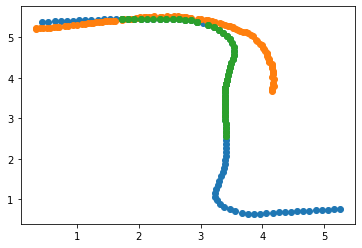

In [44]:
plt.scatter(cx[:100],cy[:100])

rx,ry=[i[0] for i in hmm],[i[1] for i in hmm]
plt.scatter(rx[:100],ry[:100])

tx,ty=[i[3][0] for i in hmm],[i[3][1] for i in hmm]
plt.scatter(tx[:100],ty[:100])

In [45]:
print(tx[-1],ty[-1])

3.6650545416978253 0.6671149442860888


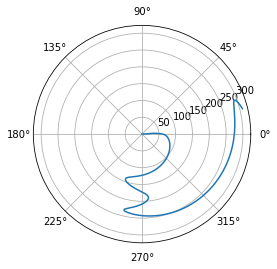

In [46]:
plt.clf()
sp = plt.subplot(1, 1, 1, projection='polar')
sp.set_theta_zero_location('E')
# sp.set_theta_direction(-1)
plt.plot(ret.yaw,[i for i in range(len(ret.yaw))])
plt.show()

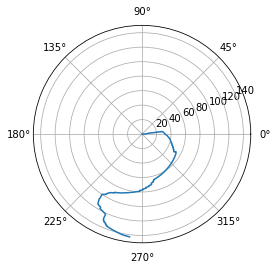

In [47]:
ryaw=[i[2] for i in hmm]
plt.clf()
sp = plt.subplot(1, 1, 1, projection='polar')
sp.set_theta_zero_location('E')
# sp.set_theta_direction(-1)
plt.plot(ryaw,[i for i in range(len(ryaw))])
plt.show()

Text(0.5, 1.0, 'raspi-yaw in radians')

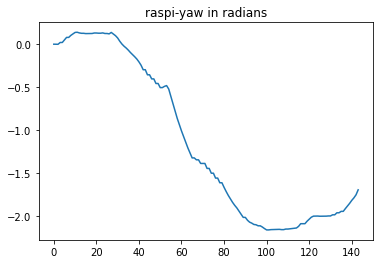

In [48]:
plt.plot(ryaw)
plt.title("raspi-yaw in radians")

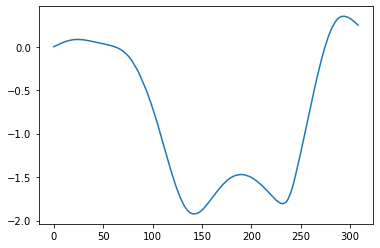

In [49]:
plt.plot(ret.yaw)

In [50]:
ster_ang=[i[4] for i in hmm]

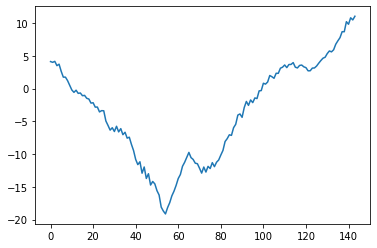

In [51]:
plt.plot(ster_ang)

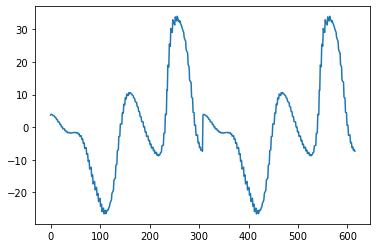

In [52]:
plt.plot(di_arr)